In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_train= pd.read_csv('/content/drive/My Drive/TFM/politicES_phase_2_train_public.csv', on_bad_lines='skip')
df_train= df_train.groupby(['label', 'ideology_multiclass'])['tweet'].apply(' '.join).reset_index()
df_train.drop('label', axis=1, inplace=True)


##  Clasificador

In [1]:
!pip install datasets
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, generation, DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback
import torch
import tensorflow as tf
from datasets import Dataset
import tqdm as notebook_tqdm

model_name = 'PlanTL-GOB-ES/longformer-base-4096-bne-es'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/longformer-base-4096-bne-es and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
label_encoder = LabelEncoder()

df_train['ideology_multiclass'] = label_encoder.fit_transform(df_train['ideology_multiclass'])

df_train, df_eval= train_test_split(df_train, test_size=0.2, stratify= df_train['ideology_multiclass'], random_state=42)

In [6]:
def tokenize_function(example):
    return tokenizer(example['tweet'], truncation=True)

dataset_train = Dataset.from_pandas(df_train)
dataset_eval = Dataset.from_pandas(df_eval)

In [7]:
# Aplicamos la tokenización a todo el dataset
tokenized_dataset_train = dataset_train.map(tokenize_function, batched=True)
tokenized_dataset_eval = dataset_eval.map(tokenize_function, batched=True)
tokenized_dataset_train

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Dataset({
    features: ['ideology_multiclass', 'tweet', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 1800
})

In [8]:
tokenized_dataset_train= tokenized_dataset_train.rename_column("ideology_multiclass", "labels")
tokenized_dataset_train= tokenized_dataset_train.remove_columns(["tweet","__index_level_0__"])

tokenized_dataset_eval= tokenized_dataset_eval.rename_column("ideology_multiclass", "labels")
tokenized_dataset_eval= tokenized_dataset_eval.remove_columns(["tweet","__index_level_0__"])  # Nos quedamos solo con los valores que necesita el modelo
tokenized_dataset_train

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 1800
})

In [9]:
from datasets import DatasetDict


# Creamos un DatasetDict para organizar los subconjuntos
final_datasets = DatasetDict({
    'train': tokenized_dataset_train,
    'validation': tokenized_dataset_eval,

})

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)  # Introducimos el data collator para trabajar con padding dinámico


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Macro-f1
180,1.222500,1.233469,0.231291
360,1.142200,1.091974,0.448122


Step,Training Loss,Validation Loss,Macro-f1
180,1.222500,1.233469,0.231291
360,1.142200,1.091974,0.448122
540,1.088100,0.962504,0.586816
720,0.920900,1.305450,0.518125
900,0.819000,0.855412,0.721822
1080,0.785600,0.900065,0.681820
1260,0.789700,1.052329,0.710621
1440,0.770000,0.957941,0.756547


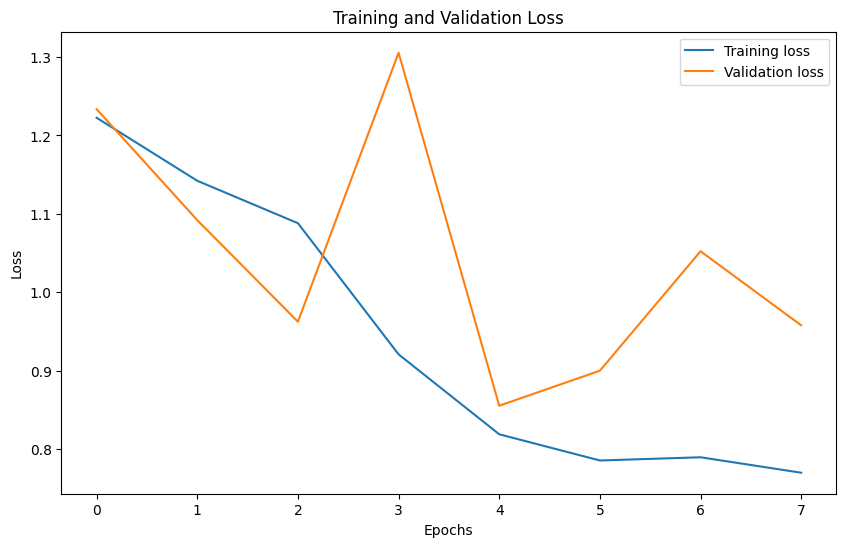

In [11]:

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Definimos la función encargada de evaluar las métricas en el entrenamiento
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)
    macro_f1 = f1_score(labels, predictions, average='macro') # o weighted si estan desbalceadas las clases

    return {'macro-F1': macro_f1}



# Definimos los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    evaluation_strategy='steps',
    eval_steps=180,
    save_strategy='steps',
    save_steps=180,
    logging_strategy='steps',
    logging_dir='./logs',
    logging_steps=180,
    load_best_model_at_end=True,
    seed=42,
)

# Inicializamos el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_datasets['train'],
    eval_dataset=final_datasets['validation'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0)]
)

# Entrenamiento y evaluación
trainer.train()
training_stats = trainer.state.log_history

# Representación de las pérdidas a lo largo de las épocas
training_loss = [e['loss'] for e in training_stats if 'loss' in e]
validation_loss = [e['eval_loss'] for e in training_stats if 'eval_loss' in e]

plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
from huggingface_hub import notebook_login

In [13]:
notebook_login()

In [14]:
model.save_pretrained("marIA-ideologiamul-4096", push_to_hub=True)

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

In [15]:
tokenizer.save_pretrained("marIA-ideologiamul-4096", push_to_hub=True)

('marIA-ideologiamul-4096/tokenizer_config.json',
 'marIA-ideologiamul-4096/special_tokens_map.json',
 'marIA-ideologiamul-4096/vocab.json',
 'marIA-ideologiamul-4096/merges.txt',
 'marIA-ideologiamul-4096/added_tokens.json',
 'marIA-ideologiamul-4096/tokenizer.json')